In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/image_classification/'

/content/drive/My Drive/image_classification


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu

%matplotlib inline

In [4]:
tl_img_aug_finetune_cnn = load_model('landslide_others_tlearn_finetune_img_aug_cnn.h5')

In [5]:
from keras.applications import vgg16
from keras.models import Model
import keras

IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['landslide' if x == 0 else 'non-landslide' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'landslide' else 1 for x in l]




In [6]:
# load sample image
sample_img_path = '/content/drive/My Drive/image_classification/sample_images/download.jpg'
sample_img = load_img(sample_img_path, target_size=IMG_DIM)
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)

(1, 150, 150, 3)


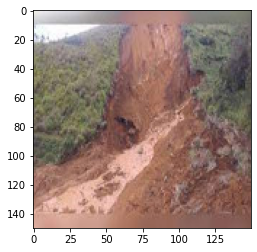

In [7]:
plt.imshow(sample_img_tensor[0])

In [8]:
tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, 
                                                                                                         verbose=0))

print('Predictions for our sample image:\n',        
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predictions for our sample image:
 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['landslide']


In [9]:
tl_img_aug_finetune_cnn.layers[0].layers[1:9]

In [10]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=tl_img_aug_finetune_cnn.layers[0].layers[1].input, outputs=layer_outputs)
# This will return a list of 8 Numpy array
# one array per layer activation
activations = activation_model.predict(sample_img_tensor)

In [11]:
print ('Sample layer shape:', activations[0].shape)
print('Sample convolution (activation map) shape:', activations[0][0, :, :, 1].shape)

Sample layer shape: (1, 150, 150, 64)
Sample convolution (activation map) shape: (150, 150)


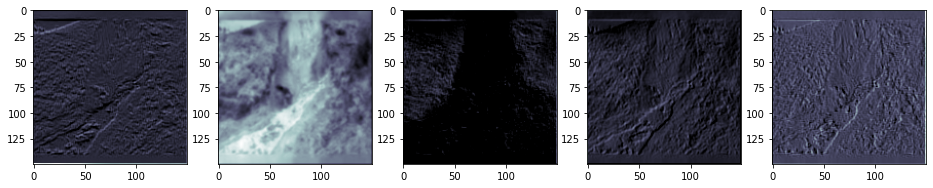

In [12]:
fig, ax = plt.subplots(1,5, figsize=(16, 6))
ax[0].imshow(activations[0][0, :, :, 10], cmap='bone')
ax[1].imshow(activations[0][0, :, :, 25], cmap='bone')
ax[2].imshow(activations[0][0, :, :, 40], cmap='bone')
ax[3].imshow(activations[0][0, :, :, 55], cmap='bone')
ax[4].imshow(activations[0][0, :, :, 63], cmap='bone')

In [13]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bone')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split()[0].strip() for fn in test_files]

print('Test dataset shape:', test_imgs.shape)

Test dataset shape: (50, 150, 150, 3)


In [15]:
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[20:30], test_labels_enc[20:30])

['landslide', 'landslide', 'landslide', 'landslide', 'landslide', 'others', 'others', 'others', 'others', 'others'] [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [16]:
!pip install pandas==0.25.3

In [17]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model Performance metrics:
------------------------------
Accuracy: 0.5
Precision: 0.4808
Recall: 0.5
F1 Score: 0.4902

Model Classification report:
------------------------------
              precision    recall  f1-score   support

   landslide       0.96      1.00      0.98        25
      others       0.00      0.00      0.00        25

   micro avg       0.96      0.50      0.66        50
   macro avg       0.48      0.50      0.49        50
weighted avg       0.48      0.50      0.49        50


Prediction Confusion Matrix:
------------------------------
                  Predicted:       
                   landslide others
Actual: landslide         25      0
        others             1      0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/drive/My Drive/image_classification/model_evaluation_utils.py:62: FutureWarning: the 'labels

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


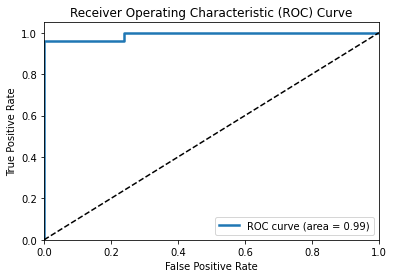

In [19]:
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])